In [1]:
#execute this cell, then press 'Restart and clear cell outputs' and execute all cells except this
!pip install -U tensorflow==2.12.0rc0
!pip install -U numpy==1.18.5

  Using cached numpy-1.18.5.zip (5.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install contractions
!pip install vaderSentiment
!pip install sweetviz
!pip install textblob

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import contractions
import sweetviz as sv
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import time

#importing the Lemming function from nltk library
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
from textblob import TextBlob

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Datasets

## Twitter labeleb data

In [4]:
twitter_posts_dir = '/content/gdrive/MyDrive/AnastasiaDatasets/data_labeled_corrected.csv'

twitter_posts = pd.read_csv(twitter_posts_dir)
twitter_posts = twitter_posts.drop(['Unnamed: 0'], axis = 1)

print(twitter_posts.shape)

(1139, 30)


In [5]:
twitter_posts.head()

,created_at_x,full_text,retweet_count,favorite_count,lang_x,hashtags,user_mentions,urls,screen_name,description,...,entities.mentions,entities.urls,entities.hashtags,entities.annotations,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,public_metrics.impression_count,referenced_tweets
0,Thu Sep 11 10:19:25 +0000 2014,Collaborazione per potenziare la sicurezza in ...,0,0,it,[],[],['http://www.melani.admin.ch/dienstleistungen/...,GovCERT_CH,"National Cyber Security Centre (NCSC), Compute...",...,NaN,"[{'start': 52, 'end': 74, 'url': 'http://t.co/...",NaN,NaN,0,0,0,0,0,NaN
1,Wed Sep 23 16:08:14 +0000 2020,Rilevate nuove versioni dell’email utilizzata ...,1,1,it,"['malspam', 'Emotet']",[],['https://csirt.gov.it/contenuti/emotet-indivi...,csirt_it,Account ufficiale del Computer Security Incide...,...,NaN,"[{'start': 109, 'end': 132, 'url': 'https://t....","[{'start': 61, 'end': 69, 'tag': 'malspam'}, {...",NaN,1,0,1,0,0,NaN
2,Wed Nov 18 16:25:02 +0000 2020,Individuate due vulnerabilità #0day nel softwa...,9,8,it,"['0day', 'Cisco', 'RCE']",[],['https://csirt.gov.it/contenuti/vulnerabilita...,csirt_it,Account ufficiale del Computer Security Incide...,...,NaN,"[{'start': 85, 'end': 108, 'url': 'https://t.c...","[{'start': 30, 'end': 35, 'tag': '0day'}, {'st...",NaN,9,1,8,0,0,NaN
3,Wed Mar 03 09:49:20 +0000 2021,Sfruttate 4 vulnerabilità #0day per violare se...,5,10,it,"['0day', 'Exchange', 'Microsoft']",[],['https://csirt.gov.it/contenuti/sfruttate-vul...,csirt_it,Account ufficiale del Computer Security Incide...,...,NaN,"[{'start': 131, 'end': 154, 'url': 'https://t....","[{'start': 26, 'end': 31, 'tag': '0day'}, {'st...",NaN,5,0,10,1,0,NaN
4,Mon Feb 08 12:07:57 +0000 2021,Malware #sLoad sfrutta #PEC con allegato malev...,11,18,it,"['sLoad', 'PEC']",[],['https://cert-agid.gov.it/news/malware-sload-...,AgidCert,Profilo ufficiale del CERT dell'Agenzia per l'...,...,NaN,"[{'start': 74, 'end': 97, 'url': 'https://t.co...","[{'start': 8, 'end': 14, 'tag': 'sLoad'}, {'st...",NaN,11,0,18,4,0,NaN


In [6]:
twitter_posts.columns

Index(['created_at_x', 'full_text', 'retweet_count', 'favorite_count',
       'lang_x', 'hashtags', 'user_mentions', 'urls', 'screen_name',
       'description', 'user_location', 'full_text1', 'predictions', 'label',
       'tweet_id', 'lang_y', 'edit_history_tweet_ids', 'created_at_y',
       'author_id', 'conversation_id', 'entities.mentions', 'entities.urls',
       'entities.hashtags', 'entities.annotations',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'public_metrics.impression_count', 'referenced_tweets'],
      dtype='object')

In [7]:
df = twitter_posts[['full_text', 'label']]
df.rename(columns={'label': 'Related'}, inplace=True)
df

<ipython-input-7-b79e0b3ade61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'label': 'Related'}, inplace=True)


,full_text,Related
0,Collaborazione per potenziare la sicurezza in ...,0.0
1,Rilevate nuove versioni dell’email utilizzata ...,1.0
2,Individuate due vulnerabilità #0day nel softwa...,1.0
3,Sfruttate 4 vulnerabilità #0day per violare se...,1.0
4,Malware #sLoad sfrutta #PEC con allegato malev...,1.0
...,...,...
1134,CERT-GIB at the I-COMference http://t.co/Iw7Fy26z,0.0
1135,Never say never again die Zweite https://t.co/...,0.0
1136,https://t.co/BmwtbRvUWR\n \n𝐂𝐓𝐅 𝐈𝐧𝐭𝐞𝐫𝐧𝐚𝐭𝐢𝐨𝐧𝐚𝐥 ...,0.0
1137,5 years ago today 🥹 https://t.co/c4uTi8Ubop,0.0


# Preprocessing


### Remove links

In [8]:
import re

def preprocessing(text):
    text = re.sub(r'http\S+', ' ', text)

    return text


In [9]:
df['original_text'] = df['full_text']

df['full_text'] = df['full_text'].apply(preprocessing)
df['full_text']

<ipython-input-9-19febbbdc517>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original_text'] = df['full_text']
<ipython-input-9-19febbbdc517>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text'] = df['full_text'].apply(preprocessing)


0       Collaborazione per potenziare la sicurezza in ...
1       Rilevate nuove versioni dell’email utilizzata ...
2       Individuate due vulnerabilità #0day nel softwa...
3       Sfruttate 4 vulnerabilità #0day per violare se...
4       Malware #sLoad sfrutta #PEC con allegato malev...
                              ...                        
1134                       CERT-GIB at the I-COMference  
1135                   Never say never again die Zweite  
1136     \n \n𝐂𝐓𝐅 𝐈𝐧𝐭𝐞𝐫𝐧𝐚𝐭𝐢𝐨𝐧𝐚𝐥 𝐌𝐞𝐭𝐚𝐑𝐞𝐝 𝟐𝟎𝟐𝟏 - 𝐍𝐎𝐖 ➡️ ...
1137                                5 years ago today 🥹  
1138                          So you know what to do\n\n 
Name: full_text, Length: 1139, dtype: object

### Translate posts

In [10]:
pip install googletrans==4.0.0-rc1


In [14]:
pip install translate


In [17]:
from translate import Translator

def translate_to_english(text):
    translator = Translator(to_lang="english", from_lang="auto")
    translated_text = translator.translate(text)
    return translated_text


In [18]:
df['full_text'] = df['full_text'].apply(translate_to_english)
df

<ipython-input-18-888fba13ca89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text'] = df['full_text'].apply(translate_to_english)


,full_text,Related,original_text
0,'AUTO' IS AN INVALID SOURCE LANGUAGE . EXAMPLE...,0.0,Collaborazione per potenziare la sicurezza in ...
1,'AUTO' IS AN INVALID SOURCE LANGUAGE . EXAMPLE...,1.0,Rilevate nuove versioni dell’email utilizzata ...
2,'AUTO' IS AN INVALID SOURCE LANGUAGE . EXAMPLE...,1.0,Individuate due vulnerabilità #0day nel softwa...
3,'AUTO' IS AN INVALID SOURCE LANGUAGE . EXAMPLE...,1.0,Sfruttate 4 vulnerabilità #0day per violare se...
4,'AUTO' IS AN INVALID SOURCE LANGUAGE . EXAMPLE...,1.0,Malware #sLoad sfrutta #PEC con allegato malev...
...,...,...,...
1134,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,0.0,CERT-GIB at the I-COMference http://t.co/Iw7Fy26z
1135,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,0.0,Never say never again die Zweite https://t.co/...
1136,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,0.0,https://t.co/BmwtbRvUWR\n \n𝐂𝐓𝐅 𝐈𝐧𝐭𝐞𝐫𝐧𝐚𝐭𝐢𝐨𝐧𝐚𝐥 ...
1137,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,0.0,5 years ago today 🥹 https://t.co/c4uTi8Ubop


tokenize + embeddings

In [ ]:
# pip install --upgrade tensorflow

In [19]:
!pip install keras-tuner
!pip install --upgrade paramiko cryptography


In [20]:
import numpy as np
import pandas as pd
import os
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from sklearn import preprocessing

import nltk # NLP
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from keras_tuner.tuners import RandomSearch


In [22]:
# seed initialization
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [23]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [24]:
df

,full_text,Related,original_text
0,'AUTO' IS AN INVALID SOURCE LANGUAGE . EXAMPLE...,0.0,Collaborazione per potenziare la sicurezza in ...
1,'AUTO' IS AN INVALID SOURCE LANGUAGE . EXAMPLE...,1.0,Rilevate nuove versioni dell’email utilizzata ...
2,'AUTO' IS AN INVALID SOURCE LANGUAGE . EXAMPLE...,1.0,Individuate due vulnerabilità #0day nel softwa...
3,'AUTO' IS AN INVALID SOURCE LANGUAGE . EXAMPLE...,1.0,Sfruttate 4 vulnerabilità #0day per violare se...
4,'AUTO' IS AN INVALID SOURCE LANGUAGE . EXAMPLE...,1.0,Malware #sLoad sfrutta #PEC con allegato malev...
...,...,...,...
1134,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,0.0,CERT-GIB at the I-COMference http://t.co/Iw7Fy26z
1135,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,0.0,Never say never again die Zweite https://t.co/...
1136,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,0.0,https://t.co/BmwtbRvUWR\n \n𝐂𝐓𝐅 𝐈𝐧𝐭𝐞𝐫𝐧𝐚𝐭𝐢𝐨𝐧𝐚𝐥 ...
1137,MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE ...,0.0,5 years ago today 🥹 https://t.co/c4uTi8Ubop


<Axes: title={'center': 'Percentage of Labels'}, ylabel='Related'>

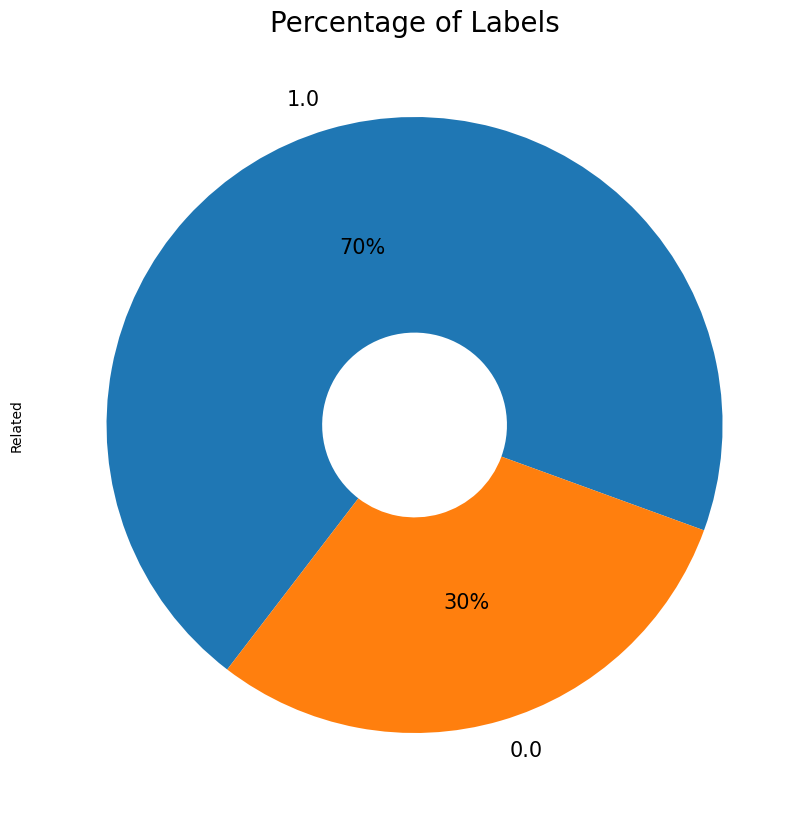

In [25]:
# check the distribution of the labels
plt.figure(figsize=(30,10))
plt.title('Percentage of Labels', fontsize=20)
df.Related.value_counts().plot(kind='pie', wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20,  textprops={'fontsize': 15})

LASER

In [26]:
!pip install torch==2.1.0

In [27]:
!pip install -q ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.5 MB/s eta 0:00:00


****LASER Encoders****

laser_encoders is the official Python package for the Facebook LASER library. It provides a simple and convenient way to use LASER embeddings in Python. It allows you to calculate multilingual sentence embeddings using the LASER toolkit. These embeddings can be utilized for various natural language processing tasks, including document classification, bitext filtering, and mining.

This encodes each of the strings as a LASER embedding (1024 dimentional vector)

For users familiar with the earlier version of LASER, you might have encountered the laserembeddings package. This package primarily dealt with LASER-1 model embeddings.

For the latest LASER-2,3 models, use the newly introduced laser_encoders package, which offers better performance and support for a wider range of languages.


In [28]:
!pip install -q laserembeddings==1.1.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.8/859.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 662.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 62.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 1.13.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.16.0 requires t

In [29]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.5 MB/s eta 0:00:00


In [30]:
!pip install fastcache
# import fasttext
import ftfy
import html
import laserembeddings
import sys

from fastcache import clru_cache
from laserembeddings import Laser
from typing import List, Union
from urllib.parse import unquote


  Preparing metadata (setup.py) ... done
  Created wheel for fastcache: filename=fastcache-1.1.0-cp310-cp310-linux_x86_64.whl size=42964 sha256=8271e46c29abc733dbc3e783d2b8c06fc22aae005e2ba3af7acd1cbebe6c40d0
  Stored in directory: /root/.cache/pip/wheels/f5/ea/fc/eebb4e5d80ccd0da9db419de1e9b156c9c2875b5d394727aff
Successfully built fastcache


In [31]:
%%bash
# DOCS: https://github.com/facebookresearch/LASER/blob/master/install_models.sh
mkdir -p models/laser/
# for FILE in bilstm.eparl21.2018-11-19.pt eparl21.fcodes eparl21.fvocab bilstm.93langs.2018-12-26.pt 93langs.fcodes 93langs.fvocab; do
for FILE in bilstm.93langs.2018-12-26.pt 93langs.fcodes 93langs.fvocab; do
    wget -cq https://dl.fbaipublicfiles.com/laser/models/$FILE -O models/laser/$FILE
done

In [32]:
!pip install config
#from src.utils.fasttest_model import language_detect
# from src.utils.punkt_tokenizer import punkt_tokenize_sentences

config = {
    "laser": {
        "base_dir":  "./models/laser",
        "bpe_codes": "./models/laser/93langs.fcodes",
        "bpe_vocab": "./models/laser/93langs.fvocab",
        "encoder":   "./models/laser/bilstm.93langs.2018-12-26.pt",
    }
}

In [33]:
# Instantiate encoder
# BUG: CUDA GPU memory is exceeded if both laser and labse are loaded together
# @clru_cache(None)
def get_laser_model():
    laser_model = Laser(
        bpe_codes = config['laser']['bpe_codes'],
        bpe_vocab = config['laser']['bpe_vocab'],
        encoder   = config['laser']['encoder'],
        tokenizer_options = None,
        embedding_options = None
    )
    return laser_model

def laser_encode(text: Union[str, List[str]], lang='autodetect', normalize=True) -> np.ndarray:
    """
    Encodes a corpus of text using LASER
    :param text: Large block of text (will be tokenized), or list of pre-tokenized sentences
    :param lang: 2 digit language code (optional autodetect)
    :return:     embedding matrix
    """
    laser_model = get_laser_model()

    if isinstance(text, str):
        # sentences = punkt_tokenize_sentences(text, lang=lang)
        sentences = ['text']

    else:
        sentences = list(text)

    embedding = laser_model.embed_sentences(sentences, lang=lang)

    if normalize:
        embedding = embedding / np.sqrt(np.sum(embedding**2, axis=1)).reshape(-1,1)

    return embedding

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, KFold, cross_validate

import tensorflow as tf
import tensorflow_addons as tfa

sns.set(style='white', context='notebook', palette='deep')


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0-rc0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you'

In [35]:
X = laser_encode(df['full_text'])
y = df['Related']


In [36]:
X[0].shape

(1024,)

In [37]:
X

array([[ 1.2180442e-02, -3.0832853e-05,  7.2970618e-03, ...,
         3.0584816e-02, -1.6538547e-03,  4.9840409e-02],
       [ 1.2180442e-02, -3.0832853e-05,  7.2970618e-03, ...,
         3.0584816e-02, -1.6538547e-03,  4.9840409e-02],
       [ 1.2180442e-02, -3.0832853e-05,  7.2970618e-03, ...,
         3.0584816e-02, -1.6538547e-03,  4.9840409e-02],
       ...,
       [ 3.9725818e-02, -1.8082262e-04, -3.4049663e-04, ...,
         6.3837310e-03,  1.8087791e-02,  3.4291953e-02],
       [ 3.9208017e-02, -1.5582093e-04,  1.8662970e-04, ...,
         6.7416290e-03,  1.8044706e-02,  3.3990018e-02],
       [ 3.8909789e-02, -1.4915124e-04,  3.0224162e-04, ...,
         5.9982697e-03,  1.7368047e-02,  3.2582257e-02]], dtype=float32)

# Load Best Model

In [38]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/gdrive/MyDrive/ExperimentalModels/ActiveLearning/2Layer_WB_tuned_FFNNmodel.h5')

In [39]:
predictions = loaded_model.predict(X)
predictions

36/36 [==============================] - 1s 5ms/step


array([[0.00421817],
       [0.00421817],
       [0.00421817],
       ...,
       [0.02977086],
       [0.00119587],
       [0.06653608]], dtype=float32)

In [42]:
threshold = 0.5
binary_predictions = np.where(predictions > threshold, 1, 0)

In [43]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef
import time

# Compute confusion matrix
def confusion(y_test, predictions):
    cm = confusion_matrix(y_test, predictions)
    accuracies = cm.diagonal()/cm.sum(axis=1)
    print(accuracies)
    print()

    # Calculate the average accuracy across all classes
    avg_accuracy = accuracies.mean()
    # Print the average accuracy
    print(avg_accuracy)
    print()

    # Print confusion matrix
    classes = np.unique(y_test)
    print("Confusion matrix:")
    print(cm)
    print()

    # Print normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix:")
    print(cm_norm)
    print()

    print("Classification report:")
    print(classification_report(y_test, predictions, target_names=[f"label {c}" for c in classes]))

    auc_roc = roc_auc_score(y_test, predictions) # y_pred_prob is the predicted probability of class 1
    mcc = matthews_corrcoef(y_test, predictions)
    print("AUC-ROC:", auc_roc)
    print("MCC:", mcc)

    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predictions, average='macro')
    print("precision:", precision)
    print("recall:", recall)
    print("f1_score:", f1_score)

In [44]:
confusion(y, binary_predictions)

[1. 0.]

0.5

Confusion matrix:
[[340   0]
 [799   0]]

Normalized confusion matrix:
[[1. 0.]
 [1. 0.]]

Classification report:
              precision    recall  f1-score   support

   label 0.0       0.30      1.00      0.46       340
   label 1.0       0.00      0.00      0.00       799

    accuracy                           0.30      1139
   macro avg       0.15      0.50      0.23      1139
weighted avg       0.09      0.30      0.14      1139

AUC-ROC: 0.5
MCC: 0.0
precision: 0.14925373134328357
recall: 0.5
f1_score: 0.22988505747126436


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif